<center><h1>chen_jacqueline_HW4</h1></center>
<br>
<br>


Name: Jacqueline Chen
<br>
Github Username: jchen741
<br>
USC ID: 7983593463

USING TWO LATE DAYS

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import os
path =os.getcwd()
print(path)
import numpy as np
from scipy.stats import bootstrap as boot_scip
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

/Users/jacy/Documents/masters/dsci 552/homework/homework-4-jchen741/notebook


Get the AReM Data Set

In [2]:
filename = path + "/data/AReM/"
word = "/notebook"
# Replace the word and update the filename variable
filename = filename.replace(word, "")
# TESTING
# name = 'bending2'
# folder_path = filename + name+'/'
# test_list = 'dataset4.csv'
# file = folder_path+test_list
# df = pd.read_csv(file,skiprows = 5, delimiter = ' ', header = None)
# display(df)
def convertcsv(root_folder,test_list):
    # getting folders, like bending 1, bending 2, etc.
    folder_path=filename+root_folder+'/'
    # selected data sets from the input
    test_list=['dataset'+str(x)+'.csv' for x in test_list]
    # directory of all the files in the folder_path
    files=os.listdir(folder_path)
    # create list to store training and test data
    train_data = []
    test_data=[]
    for file in files:
        file_path=folder_path+file
        # print(file_path)
        dataset_number = int(file.split('dataset')[1].split('.')[0])
        # for dataset 4 in bending2 with space delimiter
        if (root_folder == 'bending2' and dataset_number in [4]):
            df = pd.read_csv(file_path,skiprows = 5, sep = '\s+', header = None)
            # process df_space as needed
        # for rewriting dataset to remove trailing comma on line 485
        elif (root_folder == 'cycling' and dataset_number in [9, 14]):
            with open(file_path, 'r') as file:
                lines = file.readlines()
                # identify and modify the last line
                last_line = lines[-1].rstrip(',')  # Remove trailing comma
                # write the modified content back to the file
            with open(file_path, 'w') as file:
                file.writelines(lines[:-1])  # Write all lines except the last
                file.write(last_line)
            df = pd.read_csv(file_path,skiprows = 5, header = None)
        # all other cases
        else:
            df = pd.read_csv(file_path,skiprows = 5, header = None)
        df.columns = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        # display(df)
        # df.dropna(inplace=True)
        # separating each dataset into training list and test lists
        if file in test_list:
            test_data.append(df)
        else:
            train_data.append(df)
    train_dict=[root_folder,train_data]
    test_dict=[root_folder,test_data]
    return train_dict,test_dict

### (b) Test and Train Data

In [3]:
def buildsets(train, test, data):
    train_dict=data[0]
    test_dict=data[1]
    train[train_dict[0]]=train_dict[1]
    #train.append(data[0])
    test[test_dict[0]]=test_dict[1]

In [4]:
train_data,test_data={},{}
buildsets(train_data, test_data, convertcsv('bending1',[1,2]))
buildsets(train_data, test_data, convertcsv('bending2',[1,2]))
buildsets(train_data, test_data, convertcsv('cycling',[1,2,3]))
buildsets(train_data, test_data, convertcsv('lying',[1,2,3]))
buildsets(train_data, test_data, convertcsv('sitting',[1,2,3]))
buildsets(train_data, test_data, convertcsv('walking',[1,2,3]))
buildsets(train_data, test_data, convertcsv('standing',[1,2,3]))

### (c) Feature Extraction

#### i. Research

Minimum: The smallest value in the time series.
</br>
Maximum: The largest value in the time series.
</br>
Mean: The average value of the time series data points.
</br>
Median: The middle value of the sorted time series data.
</br>
Standard Deviation: A measure of the spread or dispersion of the data points around the mean.
</br>
Variance: The average of the squared differences from the Mean.
</br>
Skewness: A measure of the asymmetry of the probability distribution of the time series.
</br>
Percentiles (e.g., 25th, 50th, 75th): Values below which a given percentage of observations fall.
</br>
Interquartile Range (IQR): The range between the 75th percentile and 25th percentile.
</br>
Entropy: A measure of the disorder or unpredictability in the time series.

#### ii. Extraction

In [5]:
# since the data was separated into training and test sets,
# we should compute them separately first then bring them together
def new_columns(value,label,train_or_test):
    #display(value)
    new_col = []
    old_columns=value.columns
    # i = 0
    # for col in old_columns:
        #new_col.append(col)
        # i+=1
    # print(old_columns)
    new_col=value.columns
    # extracting time domain features

    min=value.min()
    max=value.max()
    mean=value.mean()
    std=value.std()
    median=value.median()
    first_quartile=value.quantile(0.25)
    third_quartile=value.quantile(0.75)
    row=[]
    # appending all values into one column for each instance
    for column in old_columns:
        row.append(min[column])
        row.append(max[column])
        row.append(mean[column])
        row.append(std[column])
        row.append(median[column])
        row.append(first_quartile[column])
        row.append(third_quartile[column])
    row.append(label)
    row.append(train_or_test)
    return row
    #print(row)

In [6]:
# creating a function to produce subscripts
def subscript_number(number):
    subscript_map = {'0': '\u2080', '1': '\u2081', '2': '\u2082', '3': '\u2083', '4': '\u2084', '5': '\u2085', '6': '\u2086', '7': '\u2087', '8': '\u2088', '9': '\u2089', '10': '\u2090', '11': '\u2091', '12': '\u2092'}
    return ''.join([subscript_map[digit] for digit in number])
def make_new_dataset(data,train_or_test):
    col1=['1','2','3','4','5','6']
    col2=['min','max','mean','std','median','1st quart','3rd quart']
    new_col=[]
    # column names
    for right in col1:
        for left in col2:
            new_col.append(left+subscript_number(right))
    new_col.append('class')
    new_col.append('train_or_test')
    new_data=[]
    for key in data:
        for value in data[key]:
            value=value.copy().drop(columns=value.columns[0])
            new_data.append(new_columns(value,key,train_or_test))
    # print(len(new_data))
    return pd.DataFrame(new_data,columns=new_col)

In [7]:
train_df=make_new_dataset(train_data,'train')
train_df

min₁   max₁      mean₁      std₁  median₁  1st quart₁  3rd quart₁  min₂  \
0   36.25  48.00  43.969125  1.618364    44.50     43.3100       44.67   0.0   
1   37.00  48.00  43.454958  1.386098    43.25     42.5000       45.00   0.0   
2   33.00  47.75  42.179812  3.670666    43.50     39.1500       45.00   0.0   
3   33.00  45.75  41.678063  2.243490    41.75     41.3300       42.75   0.0   
4   35.00  47.40  43.954500  1.558835    44.33     43.0000       45.00   0.0   
..    ...    ...        ...       ...      ...         ...         ...   ...   
64  36.25  45.50  42.959354  1.500878    42.67     42.0000       44.33   0.0   
65  36.00  47.33  44.441187  2.417797    45.00     44.6275       45.75   0.0   
66  36.25  45.75  43.187521  2.491162    44.75     39.7500       45.00   0.0   
67  29.75  48.00  46.932208  1.832665    47.50     47.2375       47.75   0.0   
68  36.33  47.67  45.399625  1.328121    45.50     45.0000       46.33   0.0   

    max₂     mean₂  ...  3rd quart₅  min₆  max₆     mean₆      std₆  median₆  \
0   1.50  0.413125  ...       23.75   0.0  2.96  0.555312  0.487826     0.49   
1   1.58  0.378083  ...       24.00   0.0  5.26  0.679646  0.622534     0.50   
2   3.00  0.696042  ...       36.33   0.0  2.18  0.613521  0.524317     0.50   
3   2.83  0.535979  ...       31.25   0.0  1.79  0.383292  0.389164     0.43   
4   1.70  0.426250  ...       36.50   0.0  1.79  0.493292  0.513506     0.43   
..   ...       ...  ...         ...   ...   ...       ...       ...      ...   
64  2.60  0.352875  ...       16.69   0.0  4.00  0.748479  0.461152     0.82   
65  4.50  0.346604  ...       14.67   0.0  5.91  1.155083  0.842087     0.94   
66  2.83  0.271271  ...       21.00   0.0  3.83  0.645458  0.567419     0.50   
67  4.60  0.429667  ...       15.50   0.0  6.58  0.991125  0.855329     0.83   
68  1.66  0.460146  ...       14.50   0.0  4.50  0.795104  0.503007     0.82   

    1st quart₆  3rd quart₆     class  train_or_test  
0         0.00        0.83  bending1          train  
1         0.43        0.87  bending1          train  
2         0.00        1.00  bending1          train  
3         0.00        0.50  bending1          train  
4         0.00        0.94  bending1          train  
..         ...         ...       ...            ...  
64        0.43        0.95  standing          train  
65        0.50        1.50  standing          train  
66        0.43        0.83  standing          train  
67        0.47        1.22  standing          train  
68        0.47        1.00  standing          train  

[69 rows x 44 columns]

In [8]:
test_df = make_new_dataset(test_data, 'test')
test_df

min₁   max₁      mean₁      std₁  median₁  1st quart₁  3rd quart₁  min₂  \
0   37.25  45.00  40.624792  1.476967   40.500     39.2500     42.0000   0.0   
1   38.00  45.67  42.812812  1.435550   42.500     42.0000     43.6700   0.0   
2   12.75  51.00  24.562958  3.737514   24.250     23.1875     26.5000   0.0   
3    0.00  42.75  27.464604  3.583582   28.000     25.5000     30.0000   0.0   
4   24.25  45.00  37.177042  3.581301   36.250     34.5000     40.2500   0.0   
5   28.75  44.75  37.561187  3.226507   36.875     35.2500     40.2500   0.0   
6   22.00  44.67  37.058708  3.710180   36.000     34.5000     40.0625   0.0   
7   23.50  30.00  27.716375  1.442253   27.500     27.0000     29.0000   0.0   
8   24.75  48.33  44.182937  7.495615   48.000     48.0000     48.0000   0.0   
9   48.00  48.25  48.004167  0.032038   48.000     48.0000     48.0000   0.0   
10  33.25  48.00  42.363563  2.068247   43.000     42.0000     43.5000   0.0   
11  37.00  50.75  45.917667  1.089027   45.635     45.0000     46.5000   0.0   
12  44.50  46.75  45.239667  0.429915   45.000     45.0000     45.3300   0.0   
13  19.33  43.50  34.227771  4.889576   35.500     30.5000     37.7500   0.0   
14  12.50  45.00  33.509729  4.850923   34.125     30.5000     36.7500   0.0   
15  15.00  46.75  34.660583  5.315110   35.000     31.0000     38.2500   0.0   
16  33.33  48.00  44.334729  2.476940   45.000     42.2500     46.5000   0.0   
17  35.50  46.25  43.174938  1.989052   43.670     42.5000     44.5000   0.0   
18  32.75  47.00  42.760562  3.398919   44.500     41.3300     45.3725   0.0   

     max₂     mean₂  ...  3rd quart₅  min₆  max₆     mean₆      std₆  median₆  \
0    1.30  0.358604  ...     36.0000   0.0  1.92  0.570583  0.582915    0.430   
1    1.22  0.372437  ...     34.5000   0.0  3.11  0.571083  0.601010    0.430   
2    6.87  0.590833  ...     27.0000   0.0  4.97  0.700188  0.693720    0.500   
3    7.76  0.449708  ...     20.7500   0.0  6.76  1.122125  1.012342    0.830   
4    8.58  2.374208  ...     21.7500   0.0  9.34  2.921729  1.852600    2.500   
5    9.91  2.080687  ...     21.5000   0.0  9.62  2.765896  1.769203    2.450   
6   14.17  2.438146  ...     21.0000   0.0  8.55  2.983750  1.815730    2.570   
7    1.79  0.363687  ...     10.7500   0.0  4.50  0.734271  0.613688    0.710   
8    3.11  0.101875  ...      5.5425   0.0  3.91  0.692771  0.675781    0.500   
9    0.43  0.007167  ...     10.0000   0.0  2.50  0.641229  0.388372    0.500   
10   4.44  0.492563  ...     17.6900   0.0  6.02  1.034021  0.985627    0.830   
11   4.87  0.324542  ...     21.0000   0.0  7.22  0.904604  0.896171    0.710   
12   1.00  0.172958  ...     21.0000   0.0  8.20  0.837250  0.835344    0.710   
13  14.50  3.995729  ...     18.6700   0.0  9.74  3.394125  1.792090    3.100   
14  13.05  4.450771  ...     18.7500   0.0  8.96  3.378479  1.787360    3.085   
15  13.44  4.200896  ...     18.5000   0.0  8.99  3.244396  1.630983    3.000   
16   3.90  0.432958  ...     17.7500   0.0  5.02  0.933000  0.673609    0.830   
17   2.12  0.506583  ...     16.5000   0.0  5.72  0.911979  0.666161    0.830   
18   3.34  0.486167  ...     18.5650   0.0  5.73  0.842271  0.722165    0.710   

    1st quart₆  3rd quart₆     class  train_or_test  
0       0.0000       1.300  bending1           test  
1       0.0000       1.300  bending1           test  
2       0.4300       0.870  bending2           test  
3       0.4700       1.300  bending2           test  
4       1.5000       3.900   cycling           test  
5       1.4100       3.770   cycling           test  
6       1.5000       4.150   cycling           test  
7       0.4300       1.000     lying           test  
8       0.3225       0.940     lying           test  
9       0.4600       0.830     lying           test  
10      0.4700       1.250   sitting           test  
11      0.4300       1.120   sitting           test  
12      0.4300       1.120   sitting           test  
13      2.1050       4.425 

In [9]:
#combining both training and test data sets
full_df=pd.concat([train_df,test_df],ignore_index=True)
full_df

min₁   max₁      mean₁      std₁  median₁  1st quart₁  3rd quart₁  min₂  \
0   36.25  48.00  43.969125  1.618364   44.500       43.31     44.6700   0.0   
1   37.00  48.00  43.454958  1.386098   43.250       42.50     45.0000   0.0   
2   33.00  47.75  42.179812  3.670666   43.500       39.15     45.0000   0.0   
3   33.00  45.75  41.678063  2.243490   41.750       41.33     42.7500   0.0   
4   35.00  47.40  43.954500  1.558835   44.330       43.00     45.0000   0.0   
..    ...    ...        ...       ...      ...         ...         ...   ...   
83  12.50  45.00  33.509729  4.850923   34.125       30.50     36.7500   0.0   
84  15.00  46.75  34.660583  5.315110   35.000       31.00     38.2500   0.0   
85  33.33  48.00  44.334729  2.476940   45.000       42.25     46.5000   0.0   
86  35.50  46.25  43.174938  1.989052   43.670       42.50     44.5000   0.0   
87  32.75  47.00  42.760562  3.398919   44.500       41.33     45.3725   0.0   

     max₂     mean₂  ...  3rd quart₅  min₆  max₆     mean₆      std₆  median₆  \
0    1.50  0.413125  ...      23.750   0.0  2.96  0.555312  0.487826    0.490   
1    1.58  0.378083  ...      24.000   0.0  5.26  0.679646  0.622534    0.500   
2    3.00  0.696042  ...      36.330   0.0  2.18  0.613521  0.524317    0.500   
3    2.83  0.535979  ...      31.250   0.0  1.79  0.383292  0.389164    0.430   
4    1.70  0.426250  ...      36.500   0.0  1.79  0.493292  0.513506    0.430   
..    ...       ...  ...         ...   ...   ...       ...       ...      ...   
83  13.05  4.450771  ...      18.750   0.0  8.96  3.378479  1.787360    3.085   
84  13.44  4.200896  ...      18.500   0.0  8.99  3.244396  1.630983    3.000   
85   3.90  0.432958  ...      17.750   0.0  5.02  0.933000  0.673609    0.830   
86   2.12  0.506583  ...      16.500   0.0  5.72  0.911979  0.666161    0.830   
87   3.34  0.486167  ...      18.565   0.0  5.73  0.842271  0.722165    0.710   

    1st quart₆  3rd quart₆     class  train_or_test  
0         0.00        0.83  bending1          train  
1         0.43        0.87  bending1          train  
2         0.00        1.00  bending1          train  
3         0.00        0.50  bending1          train  
4         0.00        0.94  bending1          train  
..         ...         ...       ...            ...  
83        2.06        4.44   walking           test  
84        2.12        4.24   walking           test  
85        0.47        1.25  standing           test  
86        0.47        1.22  standing           test  
87        0.43        1.09  standing           test  

[88 rows x 44 columns]

#### iii. Standard Deviation

In [10]:
for column in full_df.columns[:-2]:
    std_estimates = full_df[column].std()
    print(column,':',std_estimates)

min₁ : 9.569975284512807
max₁ : 4.394361684703191
mean₁ : 5.3357176583441746
std₁ : 1.7721533975028414
median₁ : 5.440054137152636
1st quart₁ : 6.1535897241853705
3rd quart₁ : 5.138924613450999
min₂ : 0.0
max₂ : 5.0627293748106394
mean₂ : 1.574163920074514
std₂ : 0.8841054781862712
median₂ : 1.4122441649745636
1st quart₂ : 0.946386191125693
3rd quart₂ : 2.1252664064059106
min₃ : 2.956462059205818
max₃ : 4.875136693954745
mean₃ : 4.008380131777648
std₃ : 0.9467102620752953
median₃ : 4.036396318784075
1st quart₃ : 4.22065788450763
3rd quart₃ : 4.171628224016796
min₄ : 0.0
max₄ : 2.183625484972341
mean₄ : 1.166114090919611
std₄ : 0.45824169747631144
median₄ : 1.145585660988056
1st quart₄ : 0.8436196840035467
3rd quart₄ : 1.5525041782503672
min₅ : 6.124001430553486
max₅ : 5.741238300951952
mean₅ : 5.675593204313176
std₅ : 1.0248979053506881
median₅ : 5.813782436530036
1st quart₅ : 6.096465201564951
3rd quart₅ : 5.531720219299494
min₆ : 0.04583815401645622
max₆ : 2.5189209776905526
mean₆ : 

In [11]:
from bootstrapped.stats_functions import std, mean

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature'])
result_list =[]
for feature in full_df.columns[:-2]:
    # Calculate bootstrap confidence interval for standard deviation
    result = bs.bootstrap(full_df[feature].values, stat_func=std, alpha=0.10, num_iterations=10000)
    standard_dev = result.value
    ci_lower = result.lower_bound
    ci_upper = result.upper_bound
    result_list.append({'Feature':feature, 'Results':standard_dev,'CI Lower': ci_lower, 'CI Upper': ci_upper})
results_df = pd.DataFrame(result_list)
print(results_df)

       Feature   Results  CI Lower   CI Upper
0         min₁  9.515445  8.333892  10.829073
1         max₁  4.369322  3.469984   5.400479
2        mean₁  5.305314  4.754445   5.919198
3         std₁  1.762056  1.584277   1.962937
4      median₁  5.409056  4.848738   6.067366
5   1st quart₁  6.118526  5.625022   6.699814
6   3rd quart₁  5.109643  4.388524   5.921313
7         min₂  0.000000  0.000000   0.000000
8         max₂  5.033882  4.690047   5.472796
9        mean₂  1.565194  1.434844   1.740591
10        std₂  0.879068  0.821679   0.960874
11     median₂  1.404197  1.274191   1.578808
12  1st quart₂  0.940994  0.851850   1.058024
13  3rd quart₂  2.113157  1.945034   2.344746
14        min₃  2.939616  2.788562   3.131633
15        max₃  4.847358  4.271761   5.525458
16       mean₃  3.985540  3.501401   4.583496
17        std₃  0.941316  0.767462   1.123960
18     median₃  4.013397  3.512752   4.636446
19  1st quart₃  4.196608  3.716745   4.796044
20  3rd quart₃  4.147858  3.634726

In [12]:
# from scipy
scipy_list = []
for column in full_df.columns[:-2]:
    result_scipy = boot_scip((full_df[column],), np.std, confidence_level = 0.90)
    ci_l, ci_u = result_scipy.confidence_interval
    scipy_list.append({'Feature':column,'CI Lower': ci_l, 'CI Upper': ci_u})
scipy_boot=pd.DataFrame(scipy_list)
scipy_boot.fillna(0, inplace=True)
print(scipy_boot)

/Users/jacy/anaconda3/lib/python3.11/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jacy/anaconda3/lib/python3.11/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


       Feature  CI Lower   CI Upper
0         min₁  8.504341  11.176317
1         max₁  3.513956   5.472738
2        mean₁  4.812363   6.006782
3         std₁  1.605656   1.988317
4      median₁  4.882897   6.098922
5   1st quart₁  5.650749   6.729413
6   3rd quart₁  4.446927   5.984055
7         min₂  0.000000   0.000000
8         max₂  4.688830   5.450195
9        mean₂  1.410782   1.712414
10        std₂  0.807647   0.942808
11     median₂  1.247726   1.553058
12  1st quart₂  0.841995   1.041556
13  3rd quart₂  1.909346   2.305777
14        min₃  2.781055   3.124351
15        max₃  4.257985   5.521374
16       mean₃  3.491781   4.552647
17        std₃  0.804759   1.201929
18     median₃  3.501002   4.599390
19  1st quart₃  3.688137   4.752526
20  3rd quart₃  3.609822   4.734452
21        min₄  0.000000   0.000000
22        max₄  2.002880   2.394916
23       mean₄  1.072742   1.218177
24        std₄  0.425335   0.488007
25     median₄  1.055775   1.198397
26  1st quart₄  0.778655   0

#### iv. Select Features

Just to summarize what this project tells me:
<br>
Building a 90% bootstrap confidence interval for the standard deviation for each of the six time series features: <br>avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23
<br>
essentially shows that 90% of the time, the feature's min, max, etc. ranges from the ci_lower to ci_upper.
<br>
Some features have zero variability, like min_2 and min_4 and that means it does not add any variability, or information, to the model. <br>

Therefore, I would not select min as an important feature.<br>

The more variability the data has, more information it brings.
So when selecting important features, I want good variability. <br>

For outliers, be careful with features that are prone to outlier, which would be the max features because it would always get the outliers.<br>

All in all, the three most important time-domain features I would select would be mean, median, and standard deviation because it would help in distinguishing different classes.


## 2. ISLR 3.7.4

### (a) Linear Train

RSS is the residual sum of squares. If RSS is lower, it means that the model fits the training data better and the model's predictions are closer to the actual observed values. If the model's true relationship is linear, training for the cubic regression would be unnecessary and project a higher RSS than the RSS for the linear regression. The cubic equation would extremely overfit the data as well. As a result, the train RSS will keep reducing as the degree of polynomial increases.

### (b) Linear Test

Because the cubic regression from training is already overfit, it would perform even worse on the test set compared to the test set of the linear regression model. As a result, the linear regression would still have a lower test RSS than the RSS of the cubic test model.

### (c) Not Linear Train

Without more information, determining whether one RSS is lower than the other is difficult to determine. We would need to know how far the true relationship varies between linearity and cubic regression. But, generally I would think that increasing the degree of the polynomial would lower the training RSS for the data.

### (d) Not Linear Testing

For the test RSS of linear and cubic regression, there is not enough information becasue it would truely depend completely on the true relationship. It would possibly require model selection, like cross validation, to determine which model fits better. If the model leans more towards the cubic relationship, the RSS for test would be lower than the linear RSS.

# HW4 BEGINS HERE

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [13]:
def make_cols(col_index,imp_features):
    cols=['class']
    for col2 in col_index: 
        for col1 in imp_features:
            cols.append(col1+subscript_number(col2))
    return cols

In [14]:
binary_set = make_cols(['1','2','6'],['mean','median','std'])
binary_traindf=train_df[binary_set].copy()
binary_traindf['class']=binary_traindf['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
binary_traindf

class      mean₁  median₁      std₁     mean₂  median₂      std₂  \
0   bending  43.969125    44.50  1.618364  0.413125     0.47  0.263111   
1   bending  43.454958    43.25  1.386098  0.378083     0.47  0.315566   
2   bending  42.179812    43.50  3.670666  0.696042     0.50  0.630860   
3   bending  41.678063    41.75  2.243490  0.535979     0.50  0.405469   
4   bending  43.954500    44.33  1.558835  0.426250     0.47  0.338690   
..      ...        ...      ...       ...       ...      ...       ...   
64    other  42.959354    42.67  1.500878  0.352875     0.47  0.313585   
65    other  44.441187    45.00  2.417797  0.346604     0.43  0.358113   
66    other  43.187521    44.75  2.491162  0.271271     0.00  0.328807   
67    other  46.932208    47.50  1.832665  0.429667     0.50  0.367267   
68    other  45.399625    45.50  1.328121  0.460146     0.50  0.269889   

       mean₆  median₆      std₆  
0   0.555312     0.49  0.487826  
1   0.679646     0.50  0.622534  
2   0.613521     0.50  0.524317  
3   0.383292     0.43  0.389164  
4   0.493292     0.43  0.513506  
..       ...      ...       ...  
64  0.748479     0.82  0.461152  
65  1.155083     0.94  0.842087  
66  0.645458     0.50  0.567419  
67  0.991125     0.83  0.855329  
68  0.795104     0.82  0.503007  

[69 rows x 10 columns]

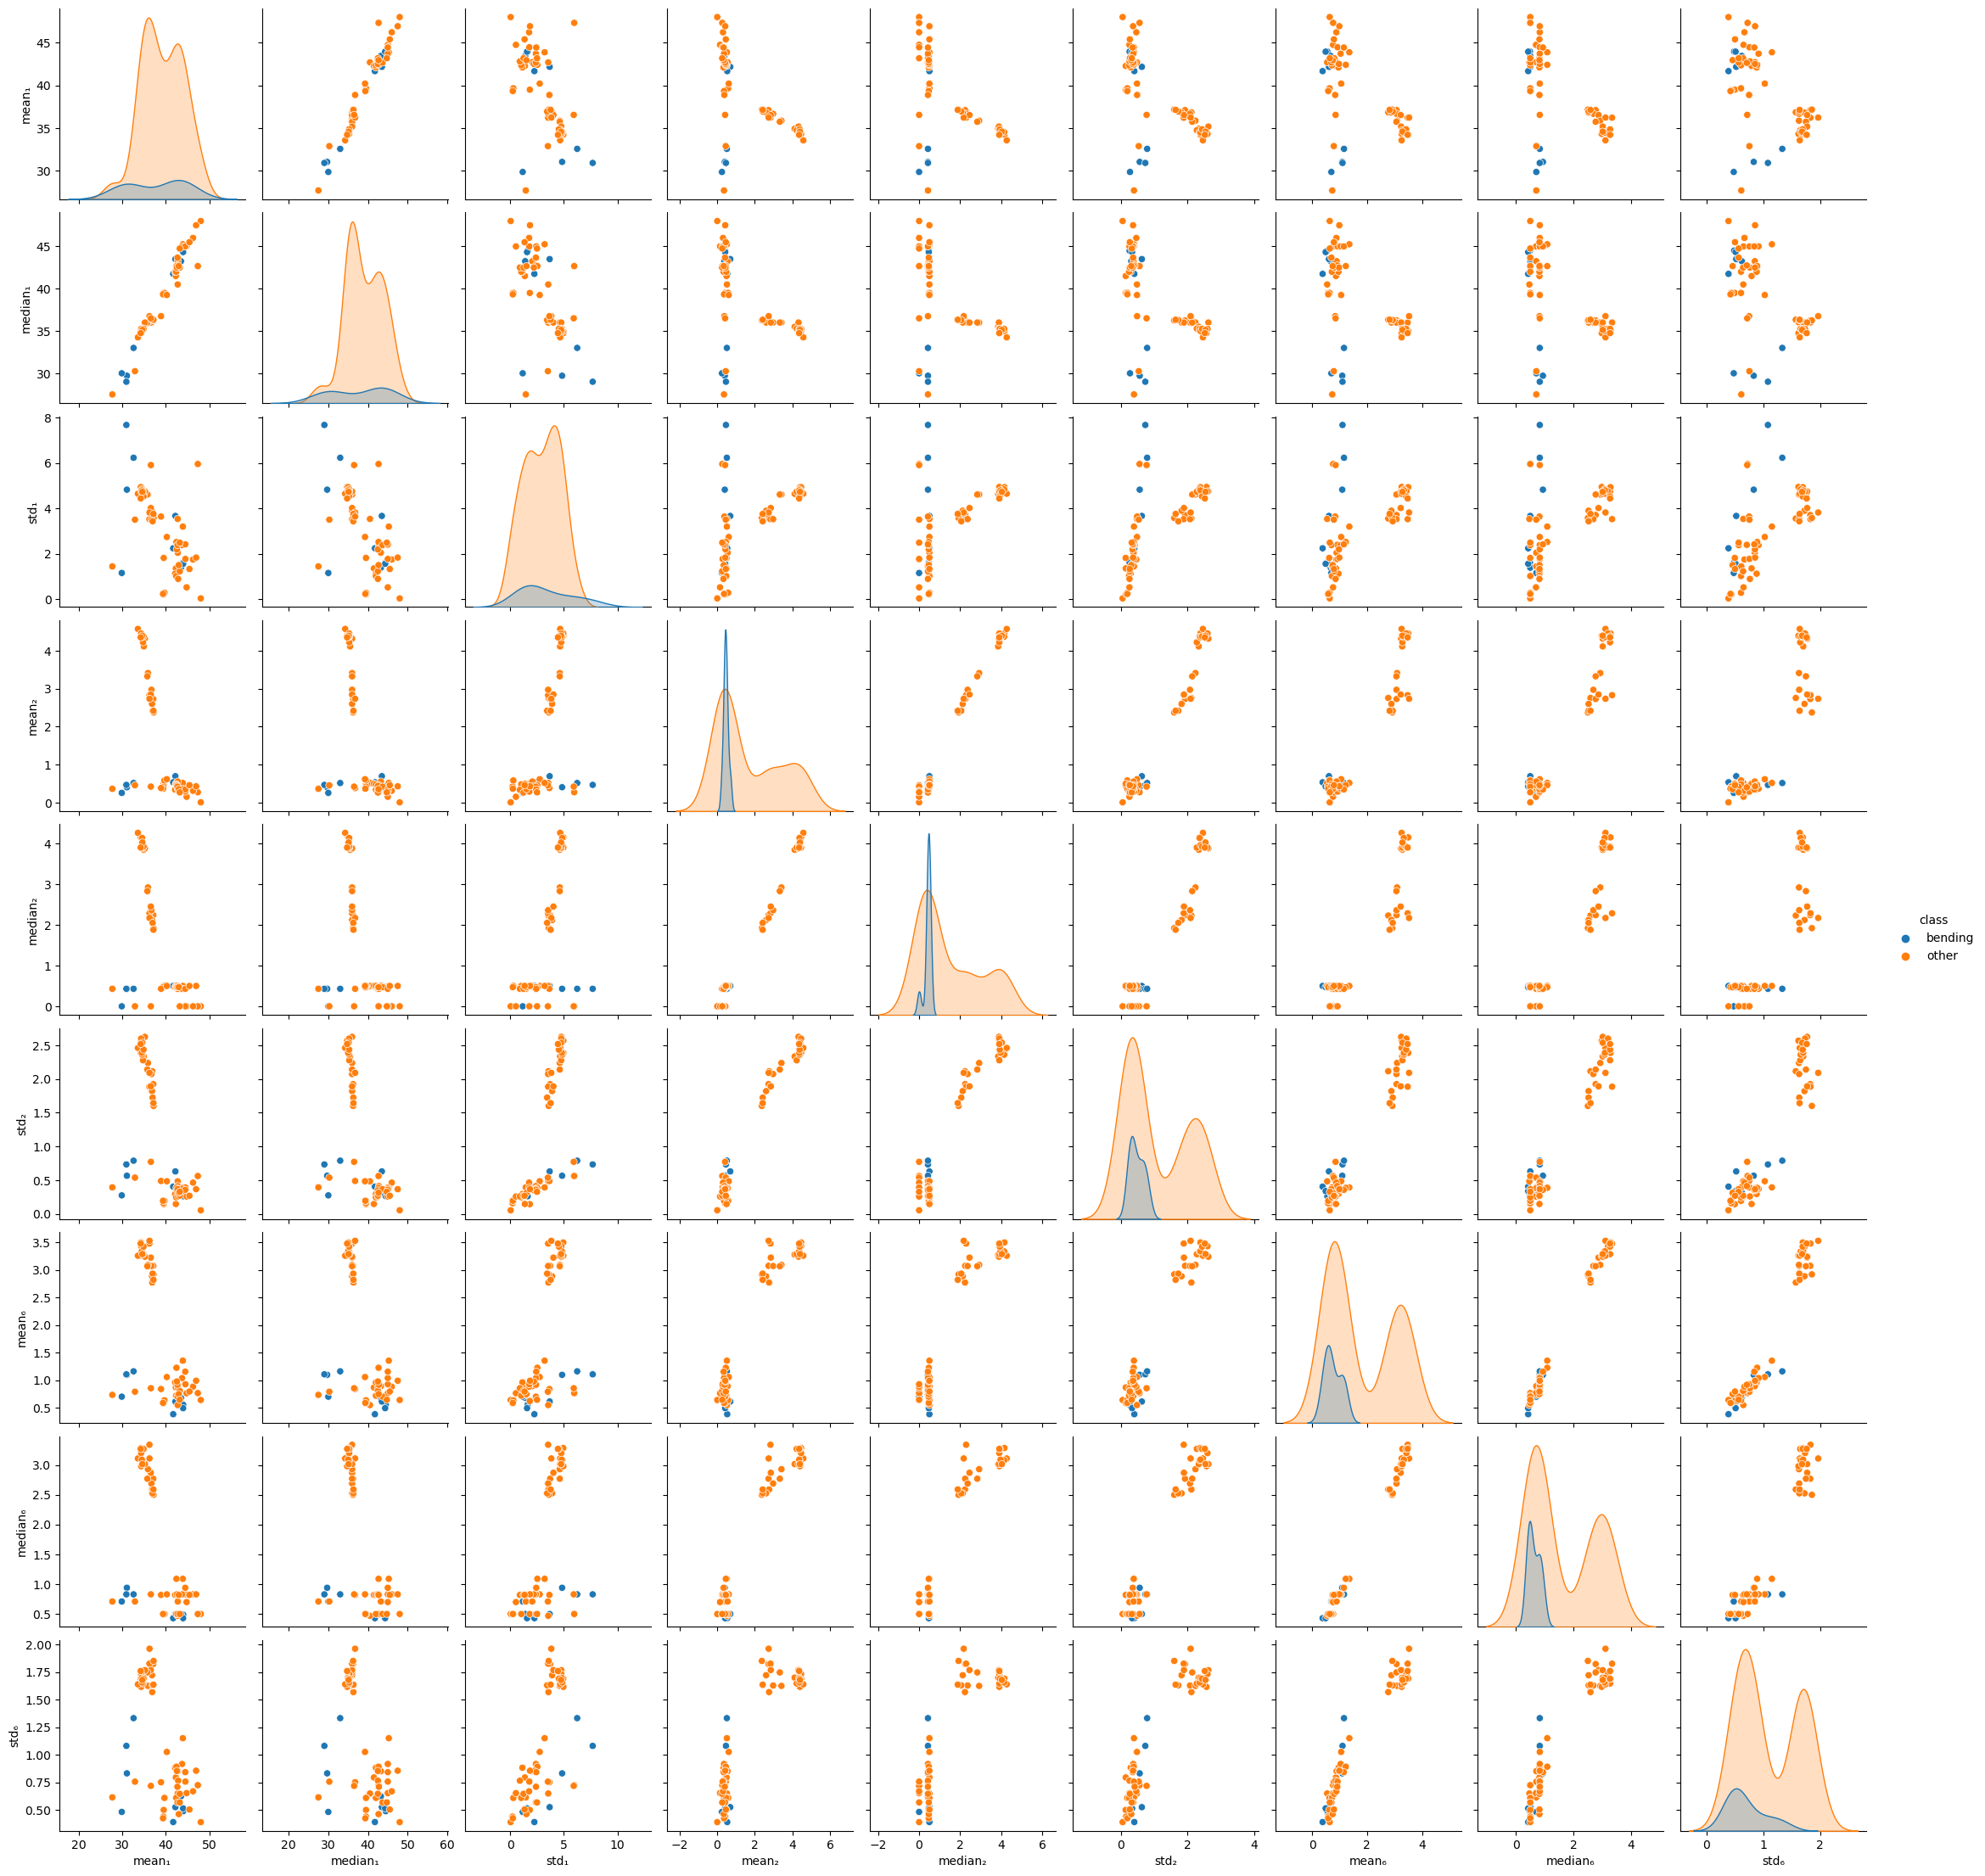

In [15]:
sns.pairplot(data=binary_traindf[binary_set],hue='class')

#### ii. Splitted Plots

In [16]:
def split_df(value,dividend):
    n = len(value)
    length = n//dividend
    start = 0
    end = length
    arr = []
    while(end<= n):
        arr.append(value.iloc[start:end].reset_index())
        # .drop(columns = 'index'))
        start = end
        end+=length
    new_split = pd.concat(arr, axis = 1).drop(columns = 'index')
    # new_columns = []
    term_counts = {}
    new_terms = []
    for col in new_split.columns:
        if col in term_counts:
            term_counts[col] += 1
            new_term = f"{col}_{term_counts[col]}"
        else:
            term_counts[col] = 1
            new_term = col
        new_terms.append(new_term)
    new_split.columns = new_terms
    # new_split = arr
    return new_split

In [17]:
def make_new_columns(value,label,train_or_test):
    # display(value)
    # new_col = []
    old_columns=value.columns
    min=value.min()
    max=value.max()
    mean=value.mean()
    std=value.std()
    median=value.median()
    first_quartile=value.quantile(0.25)
    third_quartile=value.quantile(0.75)
    row=[]
    # appending all values into one column for each instance
    for column in old_columns:
        row.append(min[column])
        row.append(max[column])
        row.append(mean[column])
        row.append(std[column])
        row.append(median[column])
        row.append(first_quartile[column])
        row.append(third_quartile[column])
    row.append(label)
    row.append(train_or_test)
    return row

In [18]:
def new_df_split(data, train_or_test, dividend):
    col1 = [str(x+1) for x in range(0,6*dividend)]
    col2 = ['min','max','mean','std','median','1st quart','3rd quart']
    new_col = []
    for right in col1:
        for left in col2:
            new_col.append(left+subscript_number(right))
    new_col.append('class')
    new_col.append('train_or_test')
    new_data=[]
    for key in data:
        for value in data[key]:
            value=value.drop(columns=value.columns[0]) # no time as time series
            new_value=split_df(value,dividend)
            new_data.append(make_new_columns(new_value,key,train_or_test))
        
    return pd.DataFrame(new_data,columns=new_col)

min₁   max₁      mean₁      std₁  median₁  1st quart₁  3rd quart₁  min₂  \
0   36.67  45.00  43.486208  1.281976   43.710     42.3300       44.50   0.0   
1   39.00  48.00  44.117042  1.359836   45.000     43.5000       45.00   0.0   
2   33.75  47.75  43.278875  3.473355   45.000     42.0000       45.25   0.0   
3   33.00  45.75  41.621208  3.118644   42.330     39.6525       44.25   0.0   
4   36.50  46.50  44.057167  1.556971   44.500     43.2500       45.00   0.0   
..    ...    ...        ...       ...      ...         ...         ...   ...   
64  38.33  45.25  42.584042  1.279371   42.500     42.0000       43.33   0.0   
65  36.00  46.25  43.413042  2.584612   45.000     42.0000       45.00   0.0   
66  37.00  45.33  42.084750  2.690071   43.125     39.5000       45.00   0.0   
67  41.25  48.00  47.507167  0.556636   47.500     47.5000       47.75   0.0   
68  45.00  47.67  46.013792  0.560762   46.000     45.5000       46.50   0.0   

    max₂     mean₂  ...  3rd quart₁₁  min₁₂  max₁₂    mean₁₂     std₁₂  \
0   1.30  0.378667  ...      23.5000    0.0   2.96  0.585750  0.487918   
1   1.30  0.250042  ...      23.7500    0.0   4.06  0.543875  0.473445   
2   3.00  0.673292  ...      33.7500    0.0   2.18  0.586083  0.491873   
3   2.83  0.623083  ...      30.5625    0.0   1.50  0.347500  0.363144   
4   1.50  0.381042  ...      36.2500    0.0   1.50  0.388333  0.478528   
..   ...       ...  ...          ...    ...    ...       ...       ...   
64  2.60  0.371750  ...      17.0000    0.0   4.00  0.714292  0.525329   
65  1.30  0.245167  ...      15.2500    0.0   5.91  1.130792  0.788698   
66  2.83  0.313083  ...      21.5000    0.0   3.83  0.716542  0.577943   
67  2.59  0.428833  ...      16.5000    0.0   5.46  0.902750  0.783585   
68  1.00  0.463375  ...      14.8125    0.0   4.50  0.826792  0.570282   

    median₁₂  1st quart₁₂  3rd quart₁₂     class  train_or_test  
0       0.50       0.4225       0.8300  bending1          train  
1       0.50       0.4300       0.7100  bending1          train  
2       0.47       0.0000       0.8700  bending1          train  
3       0.43       0.0000       0.5000  bending1          train  
4       0.00       0.0000       0.7100  bending1          train  
..       ...          ...          ...       ...            ...  
64      0.71       0.4300       0.8875  standing          train  
65      1.00       0.5000       1.4800  standing          train  
66      0.50       0.4300       0.8700  standing          train  
67      0.83       0.4700       1.0000  standing          train  
68      0.82       0.4700       1.0975  standing          train  

[69 rows x 86 columns]

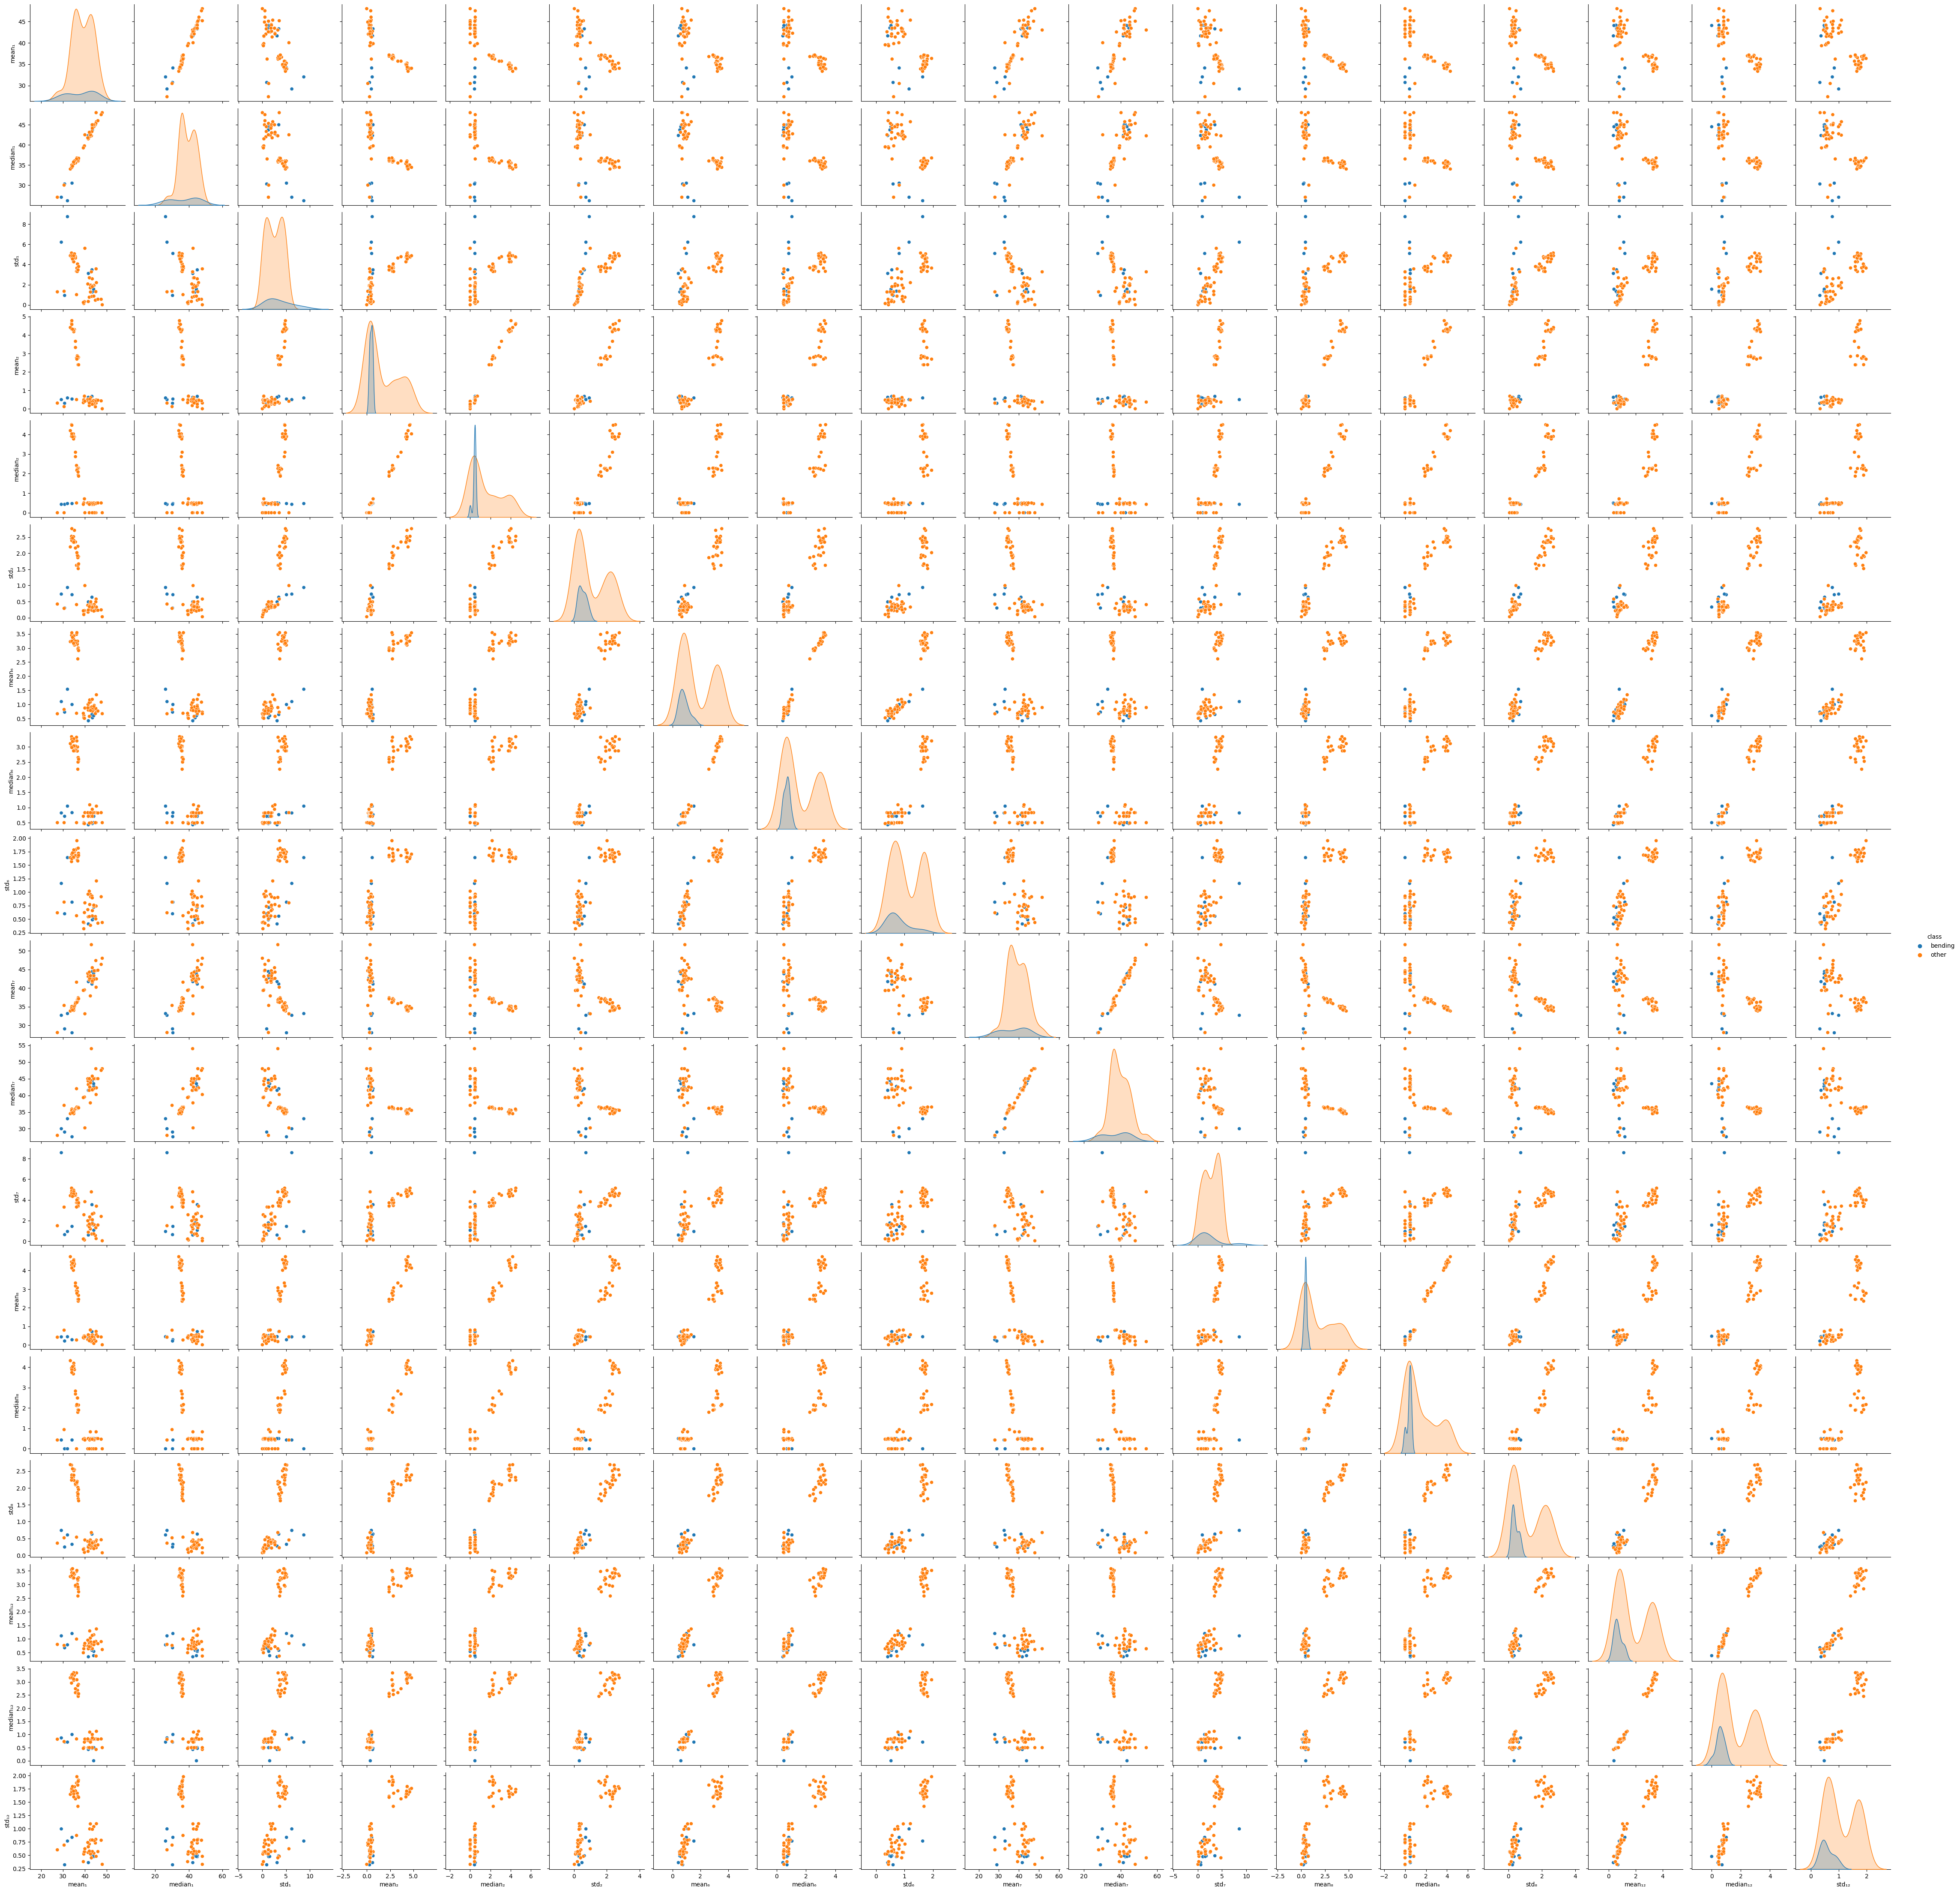

In [19]:
# splitting data and then making scatter plot for the new data
split_train = new_df_split(train_data,'train',2)
display(split_train)
# since we are trying to get both parts of the time series 1,2, and 6...
# we need both parts of time series avg_rss12, var_rss12, and var_rss23, avg_rss12_2, var_rss12_2, and var_rss23_2
# this equates to columns 1,2,6,7,8,12
cols = make_cols(col_index=['1','2','6','7','8','12'], imp_features=['mean','median','std'])

split_train['class']=split_train['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2'else 'other')
sns.pairplot(split_train[cols],hue = 'class')

#### iii. Time Series Segments

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from sklearn.model_selection import cross_val_score
def get_best_lp(model,smote=None):
    for l in range(1,21):
        rfe = RFECV(model, cv=StratifiedKFold(n_splits=5),scoring='accuracy')
        
        df=new_df_split(train_data,'train',l)
        col_index=[str(x) for x in range(1,l*6+1)]
        cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
        
        X,y=df[cols[1:]],df['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
        # for vii
        if smote!=None:
            X,y=smote.fit_resample(X, y)
        
        rfe.fit(X,y)
        chosen_cols=[]
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        for i in range(0,len(X.columns)):
            if rfe.support_[i]:
                chosen_cols.append(X.columns[i])
        # print('l=',l,'p=',len(chosen_cols),rfe.score(X,y),chosen_cols,'Class balance:',Counter(y))
        # print('l=',l,mean(cv_score),chosen_cols,'Class balance:',Counter(y))
        print(f'l={l}, p={len(chosen_cols)}, mean CV Score={cv_scores.mean()}, {chosen_cols}')

In [21]:
# with cv score
# backwards feature selection
get_best_lp(LogisticRegression(max_iter = 500))

l=1, p=2, mean CV Score=0.9285714285714286, ['mean₅', 'std₅']
l=2, p=29, mean CV Score=0.9142857142857143, ['mean₁', 'median₁', 'mean₂', 'std₂', 'mean₃', 'median₃', 'std₃', 'mean₄', 'median₄', 'mean₅', 'median₅', 'std₅', 'mean₆', 'median₆', 'std₆', 'mean₇', 'median₇', 'std₇', 'mean₈', 'median₈', 'std₈', 'std₉', 'mean₁₀', 'median₁₀', 'mean₁₁', 'std₁₁', 'mean₁₂', 'median₁₂', 'std₁₂']
l=3, p=1, mean CV Score=0.9142857142857143, ['mean₅']
l=4, p=1, mean CV Score=0.9, ['mean₁₄']
l=5, p=1, mean CV Score=0.9, ['median₂₂']
l=6, p=7, mean CV Score=0.9142857142857143, ['mean₅', 'mean₁₁', 'median₁₉', 'mean₂₂', 'mean₂₆', 'median₂₈', 'mean₃₅']
l=7, p=7, mean CV Score=0.9, ['median₃', 'mean₅', 'median₅', 'mean₁₁', 'median₁₁', 'mean₂₅', 'mean₂₈']
l=8, p=12, mean CV Score=0.9, ['mean₅', 'median₅', 'mean₁₁', 'median₁₁', 'median₁₅', 'mean₁₇', 'median₁₇', 'median₂₅', 'std₂₅', 'mean₃₄', 'median₃₄', 'mean₄₇']
l=9, p=1, mean CV Score=0.9285714285714285, ['mean₅']
l=10, p=1, mean CV Score=0.9285714285714285,

Wrong way to do cross validation would be 1. using all the data, including the test data in model selection. Cross validation should only be used on the training or validation data set. Cross validating on the test data would overfit final model build and reduce the generalizing ability of the model. Also, ignoring the need for nested cross validation and directly selecting the l value based on a single split can lead to false estimation of model performance. 
</br>

Right way is to separate the train and test data before performing cross validation and doing so on only the train data. In this case, we are dividing the train data into validation data as well without any consideration of the test data. Then, choose the best features and model and then finally at the end, test against the test data to get the test error. To do cross validation using feature selection, we need to choose the best p size which we are using rfecv for.
</br>

The best l, p pair with the best accuracy and cv score is l = 1 and p = 2 where the best features are ['mean₅', 'std₅']

#### iv. Confusion Matrix

In [22]:
# model with best l and p values and the best features
new_col = ['mean₅', 'std₅']
# data with best value of l
best_l_data=new_df_split(train_data,'train',1)

x_train,y_train=best_l_data[new_col],best_l_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train=sm.add_constant(x_train)
best_l_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw=best_l_model.predict(x_train)
threshold = 0.25
y_pred = (y_pred_raw > threshold).astype(int)
# y_pred=round(y_pred_raw)
best_l_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.71401D+00

At iterate    1    f=  5.06767D-01    |proj g|=  2.43762D-01

At iterate    2    f=  5.00276D-01    |proj g|=  3.05097D-01

At iterate    3    f=  4.83657D-01    |proj g|=  7.86271D-01

At iterate    4    f=  4.59412D-01    |proj g|=  1.25173D+00

At iterate    5    f=  4.19368D-01    |proj g|=  1.17667D+00

At iterate    6    f=  3.89237D-01    |proj g|=  3.19155D-01

At iterate    7    f=  3.83514D-01    |proj g|=  3.85389D-02

At iterate    8    f=  3.82646D-01    |proj g|=  4.97317D-02

At iterate    9    f=  3.82299D-01    |proj g|=  6.01301D-02

At iterate   10    f=  3.80257D-01    |proj g|=  6.16655D-02

At iterate   11    f=  3.65740D-01    |proj g|=  5.10496D-02

At iterate   12    f=  3.13791D-01    |proj g|=  1.28753D-01

At iterate   13    f=  2.2

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       66
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Oct 2023   Pseudo R-squ.:                  0.6945
Time:                        01:53:21   Log-Likelihood:                -8.1628
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 8.744e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.1292      8.425     -3.101      0.002     -42.643      -9.616
mean₅          1.0803      0.371      2.909      0.004       0.353       1.808
std₅           1.3020      0.543      2.397      0.017       0.238       2.366
==============================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

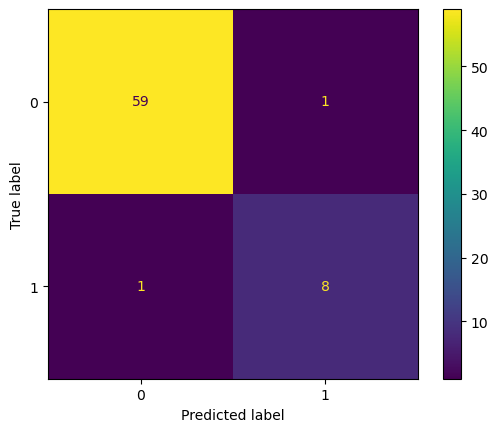

In [23]:
disp=ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred))
disp.plot()
plt.show()

AUC= 0.9703703703703703


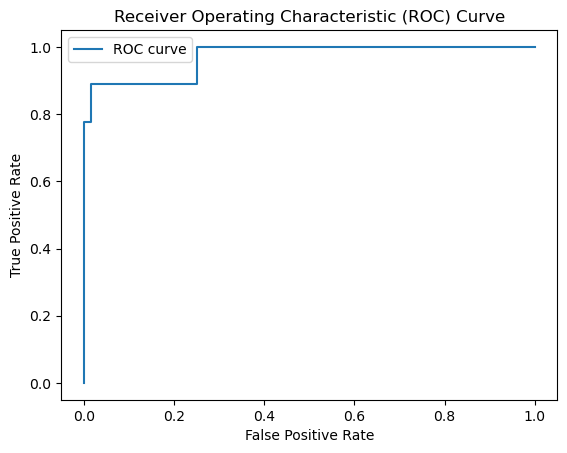

In [24]:
print('AUC=',roc_auc_score(y_train,y_pred_raw))
fpr, tpr, thresholds = roc_curve(y_train, y_pred_raw)
plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### v. Test Classifier

In [25]:
test_col = ['mean₅', 'std₅']
best_test_data = new_df_split(test_data,'test',1)
x_test, y_test = best_test_data[test_col],best_test_data['class'].apply(lambda x:1 if x == 'bending1' or x == 'bending2' else 0)
x_test = sm.add_constant(x_test)

y_pred_test_raw = best_l_model.predict(x_test)
threshold = 0.5
y_pred_test = (y_pred_test_raw > threshold).astype(int)
accuracy = accuracy_score(y_test,round(y_pred_test))
print(f'accuracy on the test set: {accuracy}')

accuracy on the test set: 0.9473684210526315


compared to a cross validation accuracy from before of .9285714285714286, the accuracy of the test dataset is higher. This is a positive sign.

#### vi. Separation

A fraction 0.19 of observations can be perfectly predicted. This might indicate that there is complete quasi-separation and shows that there is instability in calculating the logistic regression parameters. This means that the data is well separated and can possibly cause some parameters to not be identified

#### vii. Imbalance

In [26]:
from imblearn.over_sampling import SMOTE
get_best_lp(LogisticRegression(max_iter=500),SMOTE(sampling_strategy=0.2,random_state=42))


l=1, p=2, mean CV Score=0.9028571428571428, ['mean₅', 'std₅']
l=2, p=5, mean CV Score=0.9428571428571428, ['median₄', 'mean₅', 'median₅', 'mean₆', 'median₇']
l=3, p=7, mean CV Score=0.9580952380952381, ['mean₃', 'std₃', 'mean₅', 'median₅', 'mean₇', 'std₇', 'mean₁₇']
l=4, p=1, mean CV Score=0.9580952380952381, ['mean₅']
l=5, p=39, mean CV Score=0.9580952380952381, ['median₁', 'std₃', 'mean₅', 'median₅', 'mean₆', 'median₆', 'median₇', 'mean₈', 'mean₉', 'median₉', 'mean₁₁', 'median₁₁', 'mean₁₂', 'mean₁₃', 'median₁₃', 'std₁₃', 'mean₁₄', 'mean₁₅', 'mean₁₆', 'median₁₆', 'mean₁₉', 'median₁₉', 'mean₂₀', 'median₂₀', 'mean₂₁', 'median₂₁', 'std₂₁', 'mean₂₂', 'median₂₂', 'std₂₃', 'mean₂₄', 'median₂₄', 'mean₂₇', 'median₂₇', 'mean₂₈', 'median₂₈', 'mean₂₉', 'median₂₉', 'mean₃₀']
l=6, p=26, mean CV Score=0.9580952380952381, ['std₃', 'median₄', 'mean₅', 'median₅', 'mean₆', 'median₆', 'mean₁₁', 'median₁₁', 'mean₁₂', 'median₁₅', 'median₁₆', 'mean₁₈', 'median₁₉', 'std₁₉', 'mean₂₀', 'mean₂₂', 'median₂₂', '

l = 9 had the best cv score

For train data
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.34028D+01

At iterate    1    f=  4.71331D-01    |proj g|=  1.92233D+00

At iterate    2    f=  4.62607D-01    |proj g|=  1.71974D+00

At iterate    3    f=  3.97126D-01    |proj g|=  4.66433D+00

At iterate    4    f=  3.50454D-01    |proj g|=  4.46206D+00

At iterate    5    f=  1.81960D-01    |proj g|=  1.60549D+00

At iterate    6    f=  1.17060D-01    |proj g|=  7.58574D-01

At iterate    7    f=  6.84699D-02    |proj g|=  3.03670D-01

At iterate    8    f=  4.12426D-02    |proj g|=  1.66213D-01

At iterate    9    f=  2.46304D-02    |proj g|=  1.37582D-01

At iterate   10    f=  1.30065D-02    |proj g|=  7.56302D-02

At iterate   11    f=  6.91484D-03    |proj g|=  4.70529D-02

At iterate   12    f=  3.70414D-03    |proj g|=  2.10694D-02

At iterate 

 This problem is unconstrained.


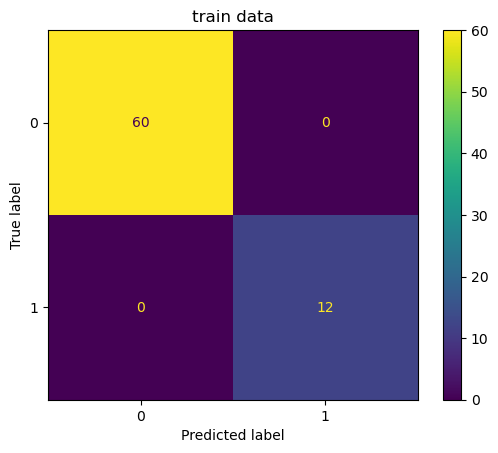

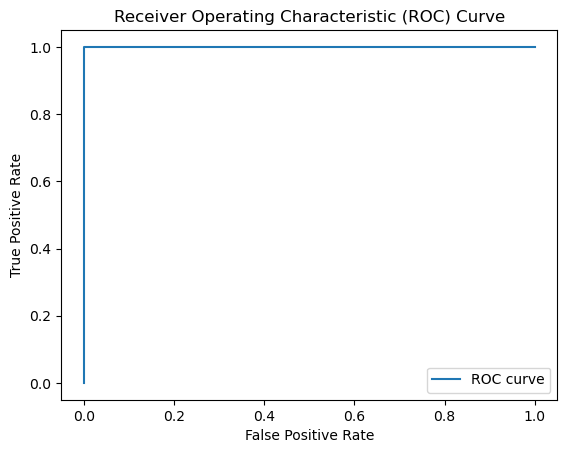

In [27]:
#Model with best L and P balanced data
print('For train data')
best_l_data=new_df_split(train_data,'train',9)
new_col = ['median₃', 'median₄', 'mean₅', 'median₅', 'mean₆', 'median₆', 'std₉', 'mean₁₁', 'median₁₁', 'mean₁₃', 'mean₁₄', 'mean₁₅', 'std₁₅', 'mean₁₇', 'median₁₇', 'mean₁₈', 'mean₂₁', 'median₂₁', 'mean₂₄', 'median₂₄', 'mean₂₅', 'std₂₅', 'mean₂₆', 'mean₃₁', 'median₃₁', 'mean₃₂', 'mean₃₄', 'median₃₄', 'mean₃₆', 'mean₃₇', 'median₃₇', 'std₃₇', 'mean₃₈', 'median₃₈', 'mean₃₉', 'median₃₉', 'mean₄₀', 'median₄₀', 'mean₄₂', 'mean₄₄', 'median₄₄', 'mean₄₅', 'median₄₅', 'mean₄₇', 'mean₅₂', 'median₅₂', 'mean₅₃', 'median₅₃', 'mean₅₄']
x_train,y_train=best_l_data[new_col],best_l_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train,y_train=SMOTE(sampling_strategy=0.2, random_state=42).fit_resample(x_train, y_train)
x_train=sm.add_constant(x_train)
best_l_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw_train=best_l_model.predict(x_train)
y_pred=round(y_pred_raw_train)

print('Accuracy=',accuracy_score(y_train,y_pred))
print('AUC=',roc_auc_score(y_train,y_pred))

disp=ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred))
disp.plot()
plt.title('train data')
plt.show()
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


For test data:
Accuracy= 1.0
AUC= 1.0


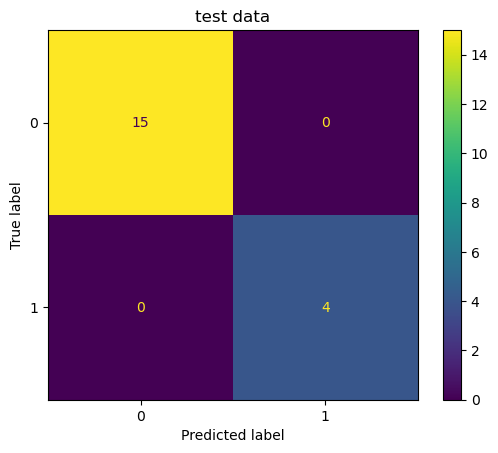

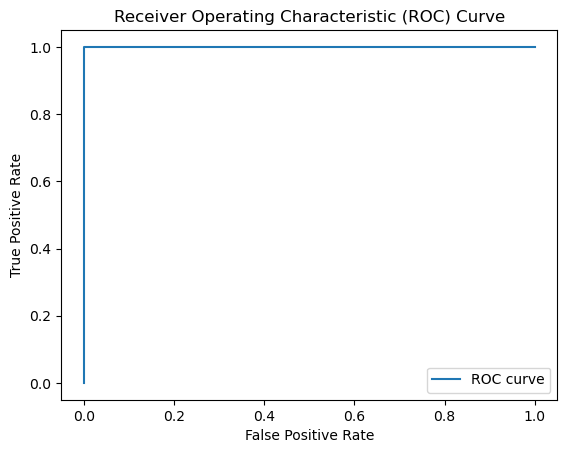

In [28]:
#for test data

print('For test data:')
test_sample=new_df_split(test_data,'test',9)
x_test,y_test=test_sample[new_col],test_sample['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_test=sm.add_constant(x_test)
y_pred_raw_test=best_l_model.predict(x_test)
y_pred=round(y_pred_raw_test)

print('Accuracy=',accuracy_score(y_test,y_pred))
print('AUC=',roc_auc_score(y_test,y_pred))

disp=ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
disp.plot()
plt.title('test data')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [29]:
for l in range(1,21):

    temp_data=new_df_split(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
    
    X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
    
    scaler = StandardScaler().fit(X)
    X=scaler.transform(X)
    
    cv=StratifiedKFold(n_splits=5)
    # L1-penalized logistic regression
    l1_model=LogisticRegressionCV(cv=5,penalty='l1',solver='liblinear',random_state=42)
    l1_model.fit(X,y)
    #print(l,accuracy_score(y,l1_model.predict(X)))
    cv_score=cross_val_score(l1_model,X,y,cv=cv)  
    #print(l,mean(cv_score))
    print('l = ',l, 'C =',l1_model.C_,'cv score = ',mean(cv_score))

l =  1 C = [2.7825594] cv score =  0.8703296703296705
l =  2 C = [0.35938137] cv score =  0.9285714285714285
l =  3 C = [0.35938137] cv score =  0.9285714285714285
l =  4 C = [0.35938137] cv score =  0.9131868131868132
l =  5 C = [0.35938137] cv score =  0.9428571428571428
l =  6 C = [2.7825594] cv score =  0.9428571428571428
l =  7 C = [0.35938137] cv score =  0.8857142857142858
l =  8 C = [0.35938137] cv score =  0.9
l =  9 C = [0.35938137] cv score =  0.8989010989010989
l =  10 C = [21.5443469] cv score =  0.9131868131868132
l =  11 C = [2.7825594] cv score =  0.9417582417582417
l =  12 C = [2.7825594] cv score =  0.9571428571428573
l =  13 C = [2.7825594] cv score =  0.9571428571428573
l =  14 C = [0.35938137] cv score =  0.9428571428571428
l =  15 C = [0.35938137] cv score =  0.9571428571428573
l =  16 C = [21.5443469] cv score =  0.9714285714285715
l =  17 C = [2.7825594] cv score =  0.9417582417582417
l =  18 C = [2.7825594] cv score =  0.9571428571428573
l =  19 C = [2.7825594]

#### ii. Comparison

the best (l,C) is (14,0.35928) because looking at the cv score and the regularization constants, this is the best.

L1 penalized was much easier to implement than the variable selection using p-values. The process ran much faster as well. LASSO can be very helpful in producing sparse solutions and identifying important features faster. Variable selection looks at a features individual significance so it may not be better in performance for complex relationships.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [30]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)

# l1_multi_models=dict()
def multi_class(data, train_or_test):
    for l in range(1,21):
        temp_data=new_df_split(data,train_or_test,l)
        col_index=[str(x) for x in range(1,l*6+1)]
        cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
        # combining bending1 and bending2 to bending
        X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
        #print(Counter(y))
        scaler = StandardScaler().fit(X)
        X=scaler.transform(X)
        cv=StratifiedKFold(n_splits=5)
        l1_model=LogisticRegressionCV(multi_class='multinomial',max_iter=1000,cv=5,penalty='l1',solver='saga',random_state=42)
        # see different solvers
        l1_model.fit(X,y)
        cv_score=cross_val_score(l1_model,X,y,cv=cv)
        # print(l,l1_model.score(X,y))
        # validation set approach
        # dividing training set into training, validation
        # logistic regression cv is logistic regression with cv
        # when choosing hyperparameters the best option is always cross validation
        print('l =',l,'c=',l1_model.C_,'cv=',mean(cv_score))

In [32]:
multi_class(train_data,'train')

l = 1 c= [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594] cv= 0.8417582417582418
l = 2 c= [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594] cv= 0.8285714285714285
l = 3 c= [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137] cv= 0.8571428571428571
l = 4 c= [21.5443469 21.5443469 21.5443469 21.5443469 21.5443469 21.5443469] cv= 0.8274725274725275
l = 5 c= [166.81005372 166.81005372 166.81005372 166.81005372 166.81005372
 166.81005372] cv= 0.8714285714285716
l = 6 c= [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594] cv= 0.8571428571428571
l = 7 c= [166.81005372 166.81005372 166.81005372 166.81005372 166.81005372
 166.81005372] cv= 0.7824175824175824
l = 8 c= [1291.54966501 1291.54966501 1291.54966501 1291.54966501 1291.54966501
 1291.54966501] cv= 0.7835164835164835
l = 9 c= [166.81005372 166.81005372 166.81005372 166.81005372 166.81005372
 166.81005372] cv= 0.7538461538461538
l = 10 c= [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594

In [33]:
def multi_model(l_value, data, train_or_test):
    l1_multi_models = dict()
    temp_data=new_df_split(data,train_or_test,l_value)
    col_index=[str(x) for x in range(1,l_value*6+1)]
    cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    scaler = StandardScaler().fit(X)
    X=scaler.transform(X)
    l1_multi=LogisticRegression(multi_class='multinomial',max_iter=1000,penalty='l1',solver='saga')
    l1_multi.fit(X,y)
    l1_multi_models[l_value]={'model':l1_multi,'scaler':scaler}
    return l1_multi_models

at l =5, the cv score is the best at 0.8714285714285716, however, the C value was extremely high, so i decided to go with l = 3, where the C value was lower and that would produce more regularized results to generalize and be less sensitive to noise.


In [34]:
l = 3
l1_multi_models=multi_model(l,train_data,'train')

/Users/jacy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [35]:
def roc_auc_multi(X,y,model,title):
    n_classes=(y.unique())
    y_test = label_binarize(y, classes=n_classes)
    #print(y_test)
    y_score=model.predict_proba(X)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    for i in range(len(n_classes)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    plt.show()

Confusion Matrix and ROC curve for MultiClass Classification where l = 3

Train error 0.0


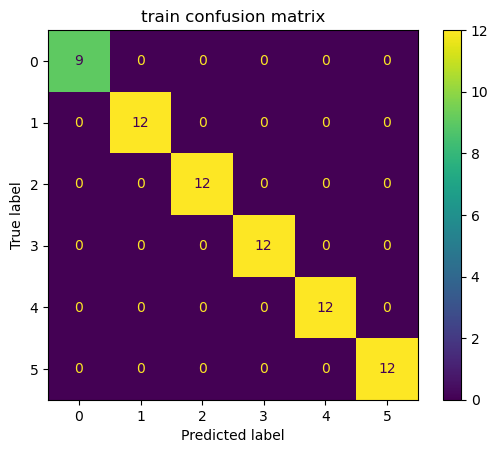

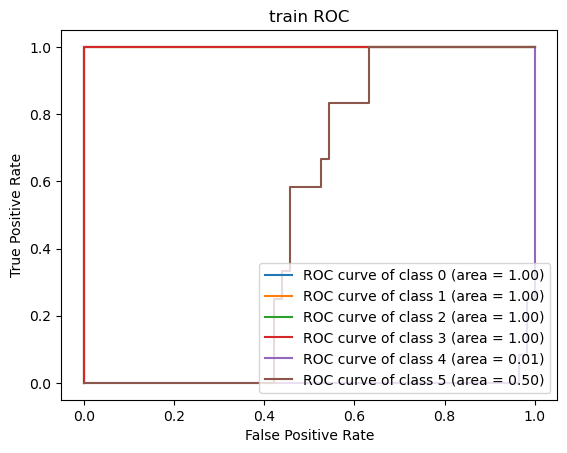

Test error 0.1578947368421053
Test Confusion matrix 


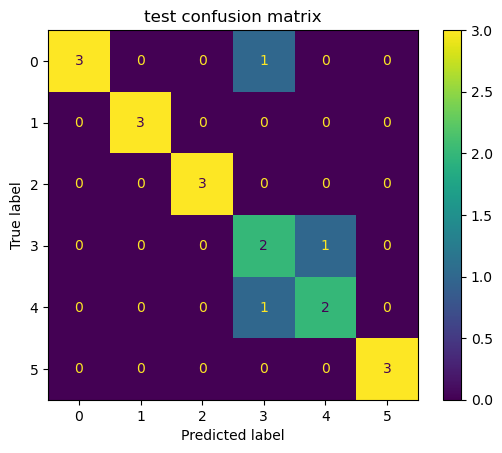

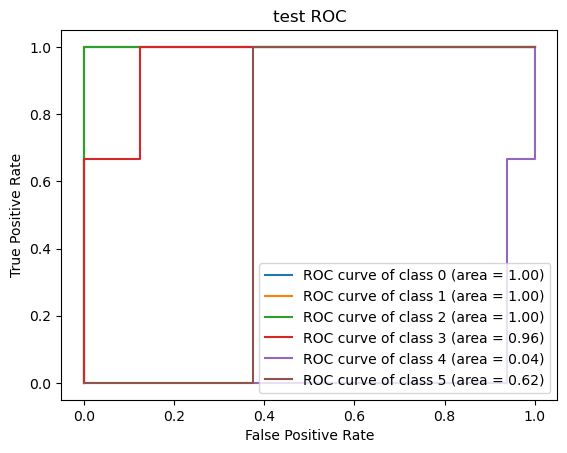

In [36]:
l=3
temp_data=new_df_split(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)

X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
X_train=l1_multi_models[l]['scaler'].transform(X)
y_pred=l1_multi_models[l]['model'].predict(X_train)
y_pred_raw=l1_multi_models[l]['model'].predict_proba(X_train)
#print(y_train)
print('Train error',1-accuracy_score(y,y_pred))

disp=ConfusionMatrixDisplay(confusion_matrix(y,y_pred))
disp.plot()
plt.title('train confusion matrix')
plt.show()
roc_auc_multi(X_train,y,l1_multi_models[l]['model'],'train ROC')

# for test data
temp_data=new_df_split(test_data,'test',l)
X_test,y_test=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

X_test=l1_multi_models[l]['scaler'].transform(X_test)
y_pred=l1_multi_models[l]['model'].predict(X_test)
y_pred_raw=l1_multi_models[l]['model'].predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
print('Test Confusion matrix ')
disp=ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
disp.plot()
plt.title('test confusion matrix')
plt.show()
roc_auc_multi(X_test,y_test,l1_multi_models[l]['model'],'test ROC')

In multiclass classification, the confusion matrix is a square matrix where each row represents the instances in a predicted class, and each column represents the instances in an actual class. Since we have 6 time series, the confusion matrix is a 6x6 matrix. This is useful in seeing how each class performs with each other.

For the ROC curve, considering each class as positive class a ROC curve is outputed and displaying on the same graph along with the AUC. This shows the sensitivity and the specificity given by the tpr and fpr respectively.

#### ii. Naive Bayes

Gaussian

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

for l in range(1,21):
    temp_data=new_df_split(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    
    cv=StratifiedKFold(n_splits=5)
    gauss_model=GaussianNB()
    print('l=',l,'cv=',mean(cross_val_score(gauss_model,X,y,cv=cv)))

l= 1 cv= 0.7956043956043957
l= 2 cv= 0.8274725274725274
l= 3 cv= 0.7527472527472527
l= 4 cv= 0.8263736263736263
l= 5 cv= 0.8395604395604396
l= 6 cv= 0.810989010989011
l= 7 cv= 0.767032967032967
l= 8 cv= 0.7813186813186812
l= 9 cv= 0.8263736263736264
l= 10 cv= 0.810989010989011
l= 11 cv= 0.8252747252747253
l= 12 cv= 0.7967032967032968
l= 13 cv= 0.767032967032967
l= 14 cv= 0.7824175824175824
l= 15 cv= 0.7824175824175824
l= 16 cv= 0.7527472527472527
l= 17 cv= 0.7395604395604395
l= 18 cv= 0.7527472527472527
l= 19 cv= 0.767032967032967
l= 20 cv= 0.7527472527472527


Using l = 5 where cv is greatest

Train error 0.02898550724637683


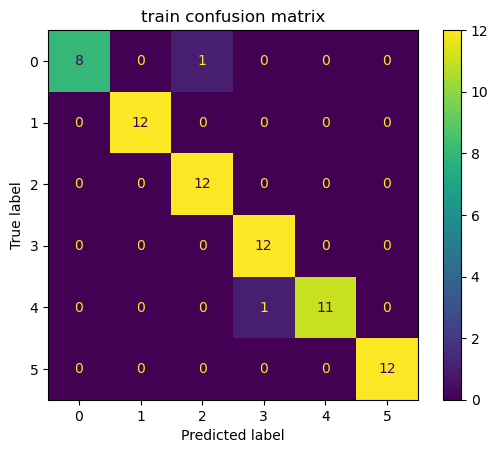

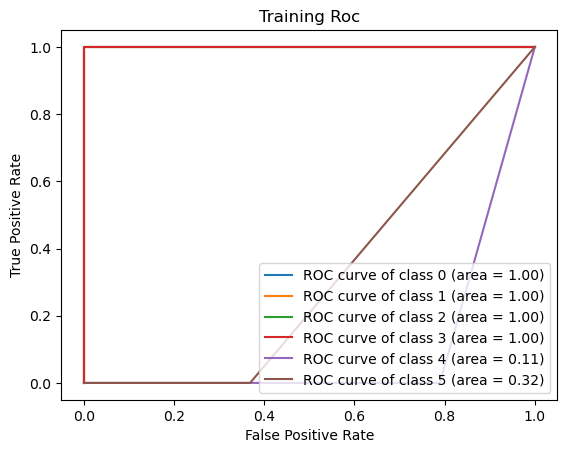

Test error 0.10526315789473684


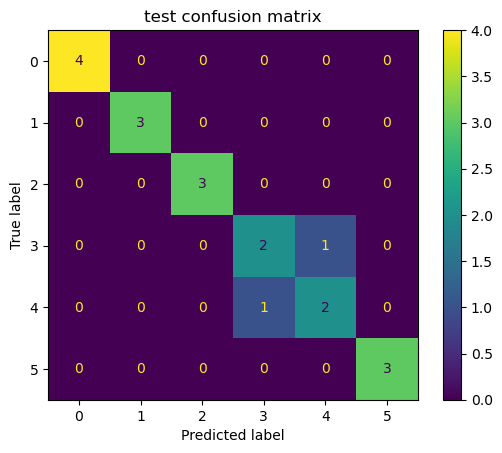

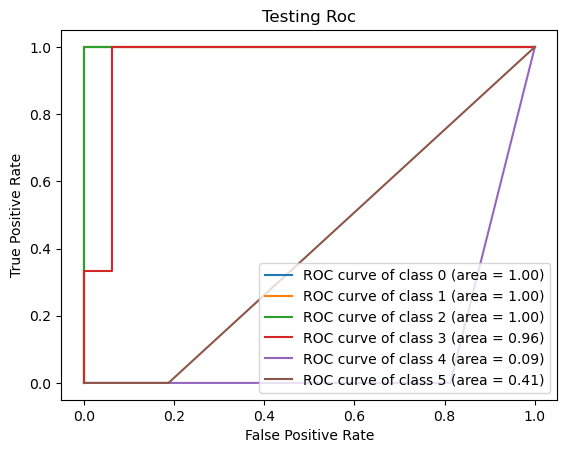

In [38]:
l=5
temp_data=new_df_split(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

gauss_model=GaussianNB()
gauss_model.fit(X,y)
y_pred=gauss_model.predict(X)
y_pred_raw=gauss_model.predict_proba(X)
print('Train error',1-accuracy_score(y,y_pred))

disp=ConfusionMatrixDisplay(confusion_matrix(y,y_pred))
disp.plot()
plt.title('train confusion matrix')
plt.show()
roc_auc_multi(X,y,gauss_model,'Training Roc')

temp_data=new_df_split(test_data,'test',l)
col_index=[str(x) for x in range(1,l*6+1)]
cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
X_test,y_test=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

y_pred=gauss_model.predict(X_test)
y_pred_raw=gauss_model.predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
disp=ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
disp.plot()
plt.title('test confusion matrix')
plt.show()
roc_auc_multi(X_test,y_test,gauss_model,'Testing Roc')

In [39]:
for l in range(1,21):
    temp_data=new_df_split(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    cv=StratifiedKFold(n_splits=5)
    multinb_model=MultinomialNB()    
    print('l=',l,'cv=',mean(cross_val_score(multinb_model,X,y,cv=cv)))

l= 1 cv= 0.7835164835164836
l= 2 cv= 0.8120879120879121
l= 3 cv= 0.7824175824175824
l= 4 cv= 0.8120879120879121
l= 5 cv= 0.8131868131868132
l= 6 cv= 0.856043956043956
l= 7 cv= 0.8120879120879121
l= 8 cv= 0.8263736263736263
l= 9 cv= 0.8406593406593407
l= 10 cv= 0.8263736263736263
l= 11 cv= 0.8120879120879121
l= 12 cv= 0.8252747252747253
l= 13 cv= 0.8263736263736263
l= 14 cv= 0.8417582417582418
l= 15 cv= 0.8263736263736263
l= 16 cv= 0.7967032967032966
l= 17 cv= 0.810989010989011
l= 18 cv= 0.7967032967032966
l= 19 cv= 0.810989010989011
l= 20 cv= 0.810989010989011


Train error 0.04347826086956519


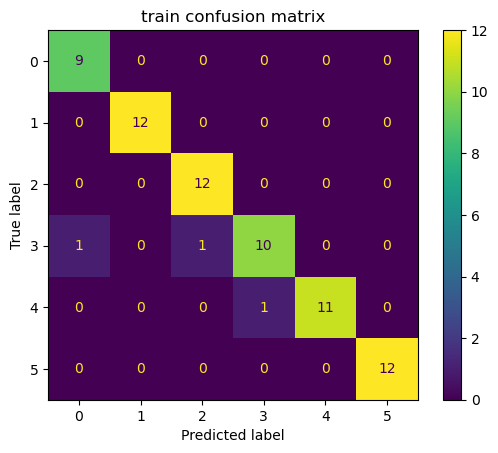

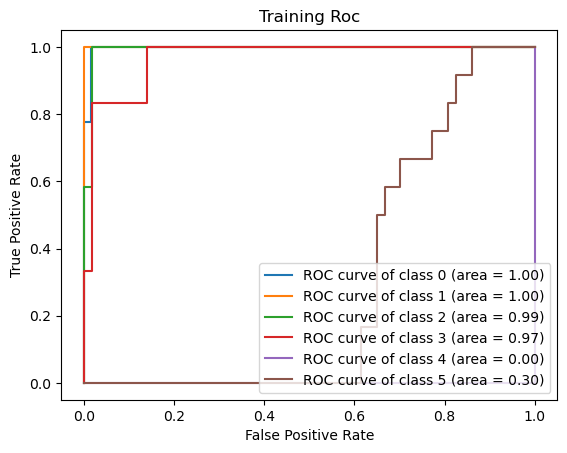

Test error 0.10526315789473684


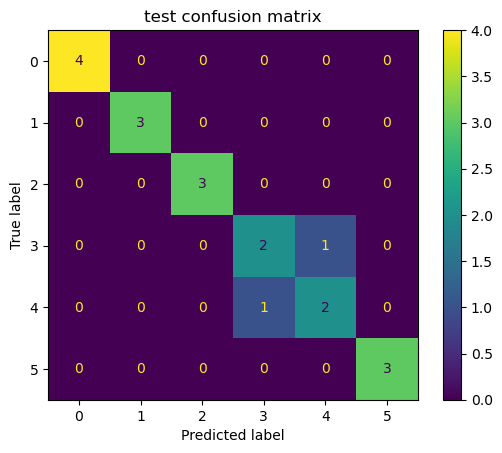

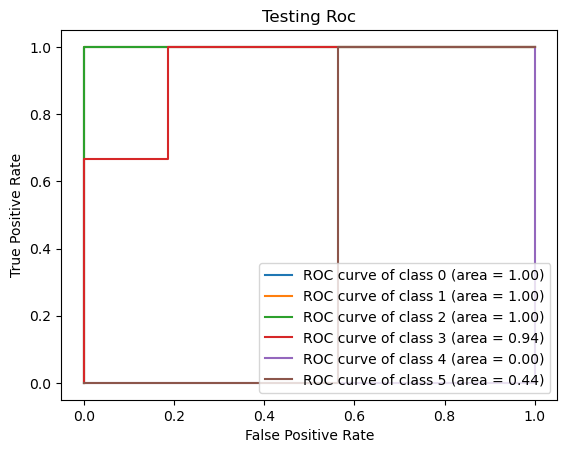

In [40]:
from sklearn.metrics import classification_report

l=6
temp_data=new_df_split(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
cols=make_cols(imp_features=['mean','median','std'],col_index=col_index)
X,y=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

multinb_model=MultinomialNB()
multinb_model.fit(X,y)
y_pred=multinb_model.predict(X)
y_pred_raw=multinb_model.predict_proba(X)
print('Train error',1-accuracy_score(y,y_pred))
disp=ConfusionMatrixDisplay(confusion_matrix(y,y_pred))
disp.plot()
plt.title('train confusion matrix')
plt.show()
roc_auc_multi(X,y,multinb_model,'Training Roc')

temp_data=new_df_split(test_data,'test',l)
X_test,y_test=temp_data[cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

y_pred=multinb_model.predict(X_test)
y_pred_raw=multinb_model.predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
disp=ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
disp.plot()
plt.title('test confusion matrix')
plt.show()
roc_auc_multi(X_test,y_test,multinb_model,'Testing Roc')

best l is 6 where cv is 0.856043956043956 with a test error of 0.10526315789473684

#### ii. Comparison

Gaussian priors seem to have lower cv values than multinomial priors, but selecting the model based on the highest cv value produced the same test error for both.
This means that they performed equally well, however, through further reserach, Multinomial Naive bayes is good at handling discrete values and Gaussian naive bayes is good at handling continuous values

## 3. ISLR 4.8.3

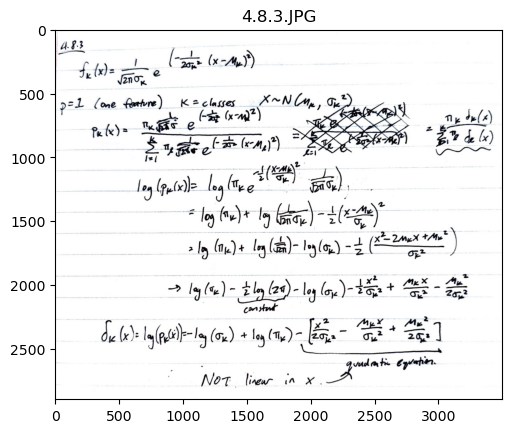

In [41]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
plt.title('4.8.3.JPG')
image = mpimg.imread('4.8.3.JPG')
plt.imshow(image)
plt.show()

## 4. ISLR 4.8.7

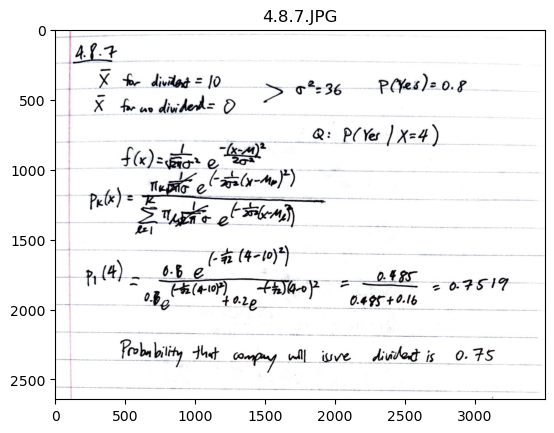

In [42]:
plt.title('4.8.7.JPG')
image = mpimg.imread('4.8.7.JPG')
plt.imshow(image)
plt.show()